# State bias

In [1]:
library(Seurat)
library(tidyverse)
library(edgeR)
library(ggplot2)
library(viridis)

source("functions-combinations.R")
source("functions-diffexp.R")
source("way_color.R")

plot_folder <- file.path(getwd(), "output")
output_folder <- file.path(getwd(), "output")

seu_diffexps <- read_rds(file.path(output_folder, "seu_diffexps.rds"))

Loading required package: SeuratObject

Loading required package: sp

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: limma

Loading required package: viridisLite



In [2]:
seu_diffexps[[2]]$condition |> table()


         D0       Cebpa       Pparg Cebpa-Pparg 
        467         888         314          88 

In [3]:
combination_ix <- 2
combination <- combinations[[combination_ix]]
seu_diffexp <- seu_diffexps[[combination_ix]]

k <- 5

linkages <- map2(combinations, seu_diffexps, function(combination, seu_diffexp){
  library(FNN)
  
  seu_diffexp <- seu_diffexp[, seu_diffexp$Phase_corrected == "G1"]
  
  knn <- knnx.index(seu_diffexp@reductions$pca@cell.embeddings, seu_diffexp@reductions$pca@cell.embeddings, k+1)
  knn <- knn[, 2:(k+1)]
  
  cell_info <- seu_diffexp@meta.data
  cell_info$ix <- 1:nrow(cell_info)
  linkage <- reshape2::melt(knn, value.name = "cell_to", varnames = c("cell_from", "k"))
  linkage <- bind_cols(
    cell_info[linkage$cell_to, ] %>% rename_all(~paste0(., "_to")),
    cell_info[linkage$cell_from, ] %>% rename_all(~paste0(., "_from"))
  )
  linkage
})

In [60]:
write_rds(linkages, file.path(output_folder, "linkages.rds"))

In [4]:

enrichments <- pmap(list(combinations, seu_diffexps, linkages), function(combination, seu_diffexp, linkage) {
  conditions_oi <- c("D0", combination[[1]], combination[[2]], paste0(combination[[1]], "-", combination[[2]]))
  print(conditions_oi)
  linkage_n <- linkage %>%
    group_by(condition_from, condition_to) %>% 
    dplyr::count() %>% 
    pivot_wider(names_from = condition_from, values_from = n, values_fill = 0)
  
  found <- as.matrix(linkage_n[, 2:ncol(linkage_n)])
  rownames(found) <- linkage_n$condition_to

  print
  found <- found[conditions_oi, conditions_oi]
  
  seu_diffexp <- seu_diffexp[, seu_diffexp$Phase_corrected == "G1"]
  cell_info <- seu_diffexp@meta.data
  expected <- matrix(rep(table(cell_info$TF)[conditions_oi], 4), nrow = 4)
  rownames(expected) <- rownames(found)
  colnames(expected) <- colnames(found)
  
  enrichment <- (found+1) / (expected+1)
  enrichment
})

[1] "D0"          "Pparg"       "Runx2"       "Pparg-Runx2"
[1] "D0"          "Cebpa"       "Pparg"       "Cebpa-Pparg"
[1] "D0"         "Cebpa"      "Mycn"       "Cebpa-Mycn"
[1] "D0"         "Cebpa"      "Myog"       "Cebpa-Myog"
[1] "D0"        "Mycn"      "Myog"      "Mycn-Myog"
[1] "D0"         "Mycn"       "Runx2"      "Mycn-Runx2"
[1] "D0"         "Mycn"       "Pparg"      "Mycn-Pparg"


In [61]:
write_rds(enrichments, file.path(output_folder, "enrichments.rds"))

Using "sugiyama" as default layout


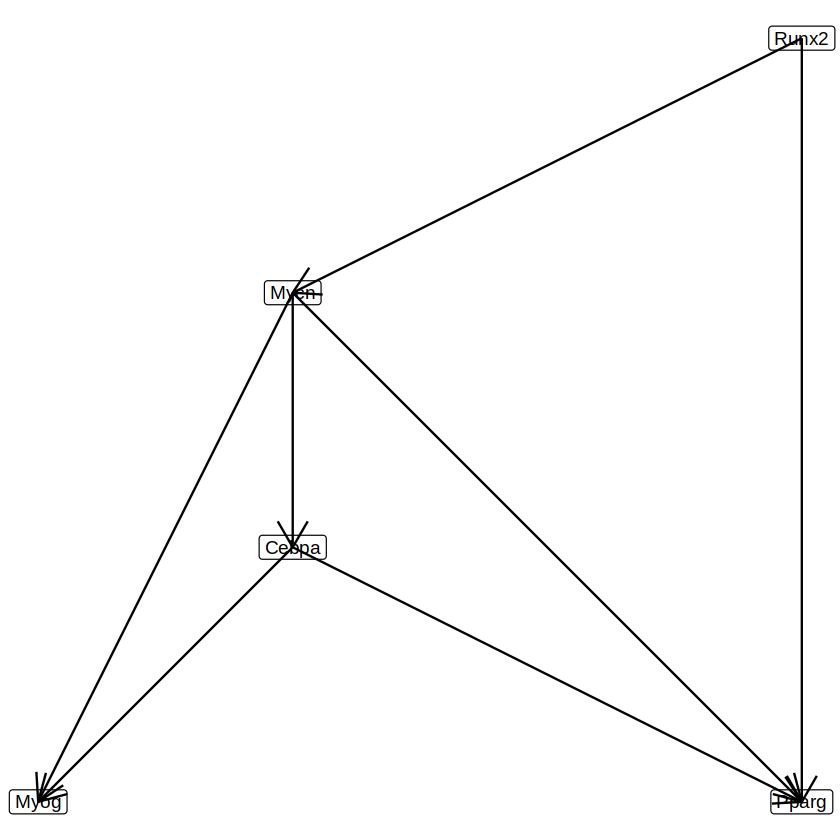

In [11]:

## Dominance
links <- enrichments %>% map_dfr(function(enrichment) {tibble(from = names(which.max(enrichment[4, 2:3])), to = names(which.min(enrichment[4, 2:3])))})
library(ggraph)

ggraph(links) + geom_node_label(aes(label = name)) + geom_edge_fan(arrow = grid::arrow()) + theme_void()




In [35]:

# Response curves dependent on vector and combinatorial
create_noncontrol_plotdata <- function(linkage, cell_info, condition_dominant, condition_shared) {
  plotdata <- linkage %>% mutate(non_control = condition_to != "D0") %>% group_by(cell_from) %>% summarize(non_control = mean(non_control))
  plotdata$cell <- plotdata$cell_from
  plotdata <- plotdata %>% left_join(cell_info, by = "cell") 
  plotdata <- bind_rows(
    plotdata %>% filter(condition %in% c(condition_dominant, condition_shared)),
    plotdata %>% filter(condition %in% c("D0")) %>% mutate(condition = condition_dominant),
    plotdata %>% filter(condition %in% c("D0")) %>% mutate(condition = condition_shared) %>% mutate(part = "shared_dominant")
  )
  plotdata
}


# create dominance based on D0-TF1-TF2 and dosage
create_dominance_plotdata <- function(linkage, cell_info, combination) {
  conditions_oi <- c("D0", combination[[1]], combination[[2]], paste0(combination[[1]], "-", combination[[2]]))
  
  condition_a <- conditions_oi[[2]]
  condition_b <- conditions_oi[[3]]
  condition_shared <- conditions_oi[[4]]
  cell_info$ix <- 1:nrow(cell_info)
  
  plotdata <- create_noncontrol_plotdata(linkage, cell_info, condition_a, condition_shared)
  
  plotdata <- linkage %>% mutate(control = condition_to == "D0", a = condition_to == condition_a, b = condition_to == condition_b, ab = condition_to == condition_shared) %>% group_by(cell_from) %>% summarize(control = mean(control), a = mean(a), b = mean(b), ab = mean(ab))
  plotdata$cell <- plotdata$cell_from
  plotdata <- plotdata %>% left_join(cell_info, by = "cell")
  plotdata
}

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


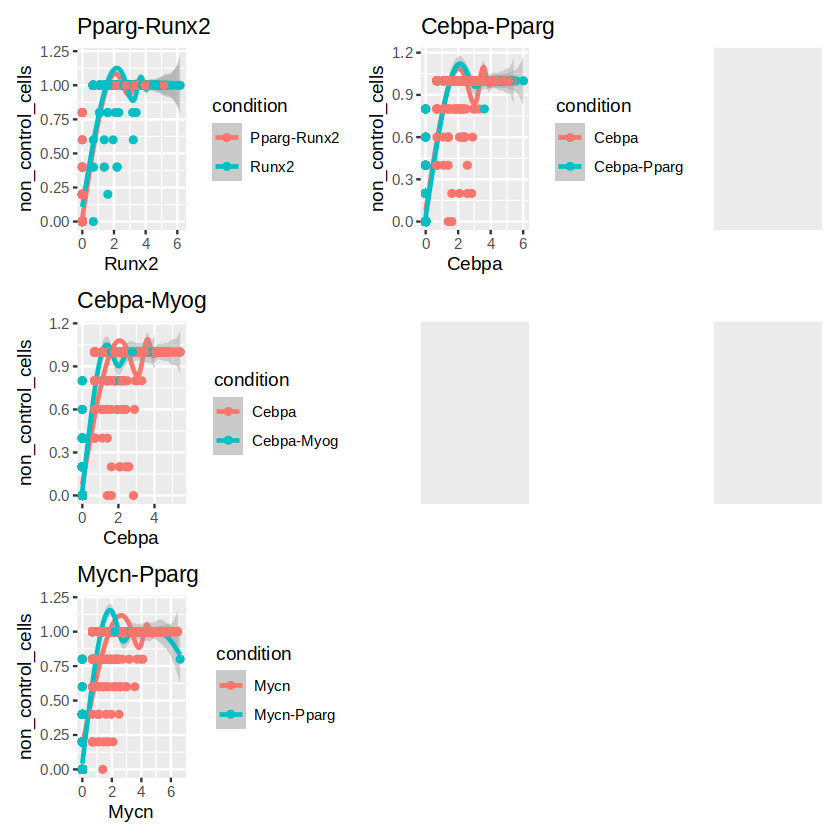

In [14]:

# main TF vs non control
plots <- pmap(list(combinations, seu_diffexps, linkages, enrichments), function(combination, seu_diffexp, linkage, enrichment){
  conditions_oi <- c("D0", combination[[1]], combination[[2]], paste0(combination[[1]], "-", combination[[2]]))
  
  if (enrichment[4, 4] == max(enrichment[4, ])){
    return(ggplot())
  } else if (enrichment[4, 3] == max(enrichment[4, ])){
    dominant <- 2
  } else if (enrichment[4, 2] == max(enrichment[4, ])){
    dominant <- 1
  }
  condition_dominant <- conditions_oi[[dominant + 1]]
  condition_shared <- conditions_oi[[4]]
  cell_info <- seu_diffexp@meta.data
  cell_info$ix <- 1:nrow(cell_info)
  plotdata <- create_noncontrol_plotdata(linkage, cell_info, condition_dominant, condition_shared)
  
  sym <- rlang::sym(paste0("logvector", dominant))
  ggplot(plotdata, aes(!!sym, non_control, color = condition)) + 
    geom_smooth(aes()) + 
    geom_point() +
    scale_x_continuous(name = conditions_oi[[dominant+1]]) + 
    scale_y_continuous(name = "non_control_cells") +
    ggtitle(conditions_oi[[4]])
})
patchwork::wrap_plots(plots)

In [33]:
data.annot <- seu_diffexp@assays$RNA@meta.features

diffexps_folder <- file.path("output/diffexp/")
diffexps <- pmap(list(combinations, seu_diffexps), function(combination, seu_diffexp) {
  scores <- read_rds(file.path(diffexps_folder, paste0(combination[[1]], "_", combination[[2]], ".rds")))
  scores$symbol <- data.annot %>% slice(match(scores$gene, gene)) %>% pull(symbol)
  scores <- scores %>% filter(gene %in% seu_diffexp@assays$RNA@meta.features$gene)
  scores
})


# main TF vs main diffexp
ix <- 6
combination <- combinations[[ix]]
combination
seu_diffexp <- seu_diffexps[[ix]]
linkage <- linkages[[ix]]
enrichment <- enrichments[[ix]]
plots <- pmap(list(combinations, seu_diffexps, linkages, enrichments, diffexps), function(combination, seu_diffexp, linkage, enrichment, diffexp){
  conditions_oi <- c("D0", combination[[1]], combination[[2]], paste0(combination[[1]], "-", combination[[2]]))
  
  # determine main TF and create plotdata
  if (enrichment[4, 3] > max(enrichment[4, 2])){
    dominant <- 2
  } else {
    dominant <- 1
  }
  condition_dominant <- conditions_oi[[dominant + 1]]
  condition_shared <- conditions_oi[[4]]
  cell_info <- seu_diffexp@meta.data
  cell_info$ix <- 1:nrow(cell_info)
  plotdata <- create_noncontrol_plotdata(linkage, cell_info, condition_dominant, condition_shared)
  
  # load diffexp scores
  sym <- rlang::sym(paste0("logFC_", dominant))
  markers <- diffexp %>% arrange(desc(!!sym)) %>% head(20) %>% pull(symbol)
  
  # add score
  seu_diffexp <- AddModuleScore(seu_diffexp, data.annot %>% filter(symbol %in% markers) |> pull(gene), name = "markers")
  plotdata$score <- seu_diffexp@meta.data[plotdata$cell, "markers1"]
  
  sym <- rlang::sym(paste0("logvector", dominant))
  ggplot(plotdata, aes(!!sym, score, color = condition)) + 
    geom_smooth(aes()) + 
    # geom_point() +
    scale_x_continuous(name = condition_dominant) + 
    scale_y_continuous(name = "module score") +
    scale_color_manual(values = setNames(c("black", "orange"), c(condition_dominant, condition_shared))) +
    theme_minimal() +
    ggtitle(condition_shared) +
    theme(legend.position = "null")
})
plot <- patchwork::wrap_plots(plots, ncol = 7) + patchwork::plot_annotation(
  title = 'Module score of top 20 differentially expressed genes of main TF',
)
plot_folder <- file.path(output_folder, "main_tf")
dir.create(plot_folder, showWarnings = FALSE)
ggsave(file.path(plot_folder, "module_scores.png"), plot, width = 21, height = 3)


[1] "Mycn"  "Runx2"

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


[1] "Pparg" "Runx2"

`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.


[1] "/srv/data/wouters/projects/tfseq/code/10_Combinations/output/dominant_balance_overview.png"

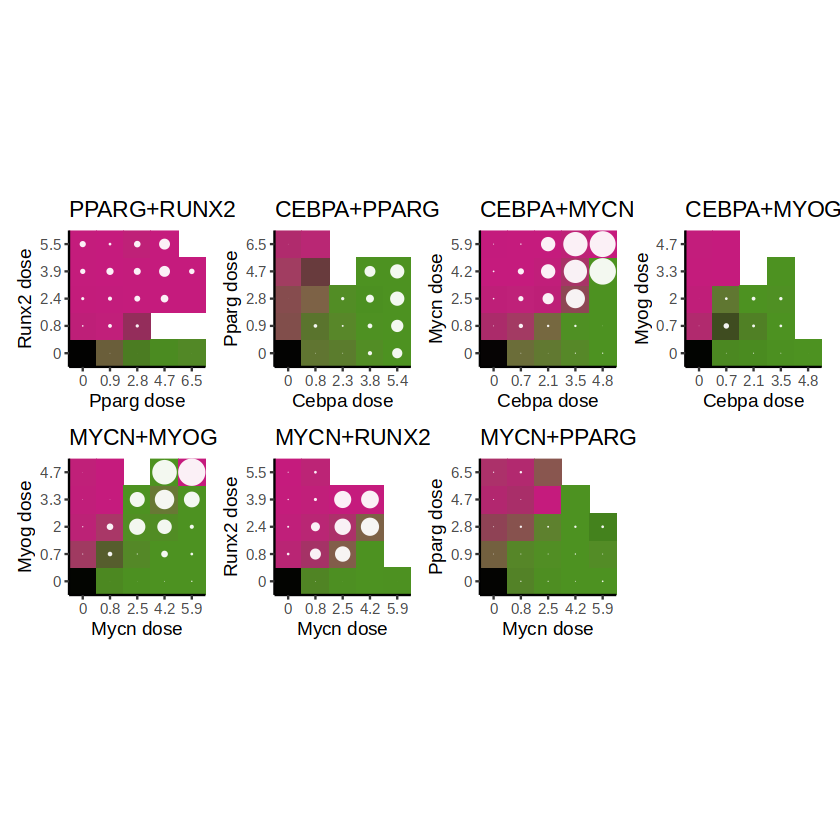

In [36]:
ix <- 1
combination <- combinations[[ix]]
combination
linkage <- linkages[[ix]]
seu_diffexp <- seu_diffexps[[ix]]
enrichment <- enrichments[[ix]]
# seu_diffexp <- seu_diffexp %>% RunPCA() %>% RunUMAP(dims = 10)

sigmoid <- function(a, b) {
  1/(1+exp(-(a + 1e-2)/(b + 1e-2)))
}

plots <- pmap(list(combinations, linkages, seu_diffexps), function(combination, linkage, seu_diffexp) {
  seu_diffexp <- seu_diffexp[, seu_diffexp$Phase_corrected == "G1"]
  cell_info <- seu_diffexp@meta.data
  cell_info$ix <- 1:nrow(cell_info)
  plotdata <- create_dominance_plotdata(linkage, cell_info, combination) %>% group_by(bin1, bin2) %>% summarize(control = mean(control), a = mean(a), b = mean(b), ab = mean(ab), n = n()) %>% ungroup()
  
  plotdata$y <- plotdata$a / (plotdata$b + plotdata$a + 1e-5)
  plotdata$x <- 1-(plotdata$control / (plotdata$control + plotdata$a + plotdata$b + 1e-5))
  
  plotdata$color <- map_colors(plotdata$x, plotdata$y)
  
  seu_diffexp@misc$bin_info1$ix <- seq(nrow(seu_diffexp@misc$bin_info1))
  seu_diffexp@misc$bin_info2$ix <- seq(nrow(seu_diffexp@misc$bin_info2))
  plotdata$binlabel1 <- (seu_diffexp@misc$bin_info1 %>% select(name, label) %>% deframe())[plotdata$bin1] %>% round(2) %>% as.character()
  plotdata$binlabel2 <- (seu_diffexp@misc$bin_info2 %>% select(name, label) %>% deframe())[plotdata$bin2] %>% round(2) %>% as.character()
  plotdata$x <- (seu_diffexp@misc$bin_info1 %>% select(name, ix) %>% deframe())[plotdata$bin1]
  plotdata$y <- (seu_diffexp@misc$bin_info2 %>% select(name, ix) %>% deframe())[plotdata$bin2]
  
  ggplot(plotdata) + 
    geom_tile(aes(bin1, bin2, fill = color)) + 
    ggforce::geom_circle(aes(x0=x, y0=y, r = (ab+1e-5)/2), fill = "#FFFFFFEE", color = "#00000000", data = plotdata %>% filter(n > 1)) +
    scale_size_continuous(limits = c(0, 1), range = c(0, 5)) +
    # geom_text(aes(bin1, bin2, label = n)) +
    scale_fill_identity() + 
    scale_x_discrete(name = paste0(combination[[1]], " dose"), labels = deframe(seu_diffexp@misc$bin_info1 %>% select(name, label)), expand = c(0, 0)) + 
    scale_y_discrete(name = paste0(combination[[2]], " dose"), labels = deframe(seu_diffexp@misc$bin_info2 %>% select(name, label)), expand = c(0, 0)) +
    theme_minimal() +
    ggtitle(paste0(toupper(combination[[1]]), "+", toupper(combination[[2]]))) +
    theme(legend.position = "none") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    # theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
    theme_classic() +
    coord_equal()
})
order <- c(
  1, # Pparg-Runx2: Absolute dominance
  4, # Cebpa-Myog: Either extreme
  2, 7, # Cebpa-Pparg and Mycn-Pparg: Dominance, but clear mixing
  3, 5, 6 # Cebpa-Mycn, Mycn-Runx2, Mycn-Myog: Dosage-dependent formation of a "unique" phenotype
)
order <- seq(length(plots))
plot<- patchwork::wrap_plots(plots[order], ncol = 4)
plot
ggsave(file.path(output_folder, "dominant_balance_overview.png"), plot = plot, width = 8, height = 5)
ggsave(file.path(output_folder, "dominant_balance_overview.pdf"), plot = plot, width = 8, height = 5)
normalizePath(file.path(output_folder, "dominant_balance_overview.png"))

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


[1] "/srv/data/wouters/projects/tfseq/code/10_Combinations/output/main_tf/dominant_balance_legend.png"

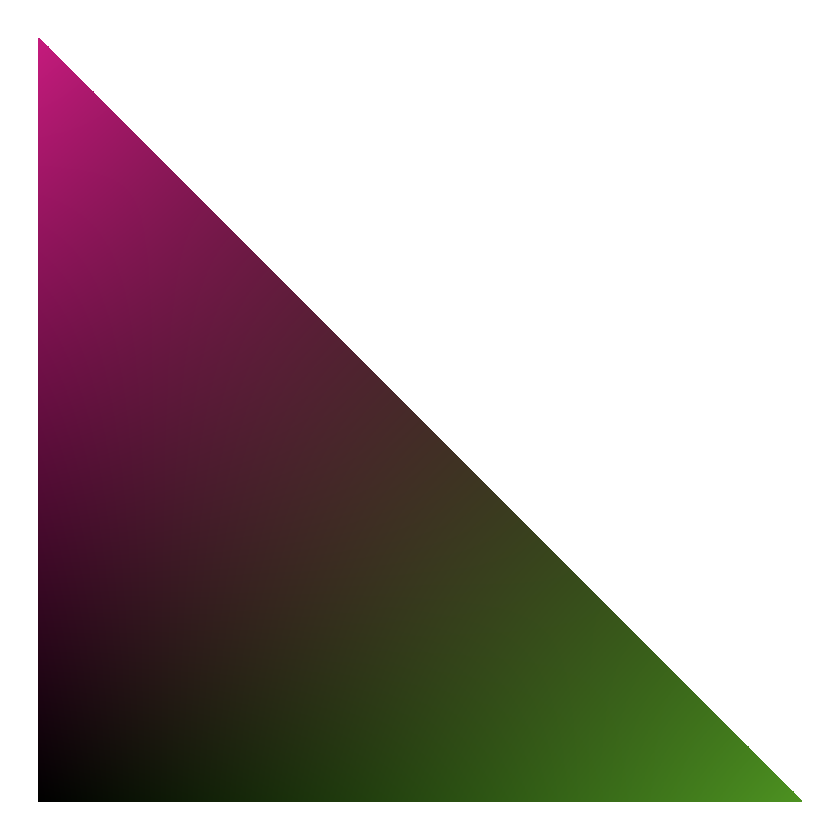

In [37]:

# triangle legend
plotdata <- expand.grid(a = seq(0, 1, length.out = 1000), b = seq(0, 1, length.out = 1000))
plotdata$color <- map_colors(plotdata$a, plotdata$b, reverse = TRUE)
plotdata <- plotdata %>% filter(a+b<1)

plot <- ggplot(plotdata) + 
  geom_tile(aes(a, b, fill = color)) + 
  scale_fill_identity() + 
  theme_minimal() +
  theme_void() +
  coord_equal() +
  coord_flip()
plot
ggsave(file.path(plot_folder, "dominant_balance_legend.png"), plot = plot, width = 3, height = 3)
normalizePath(file.path(plot_folder, "dominant_balance_legend.png"))


[1] "/srv/data/wouters/projects/tfseq/code/10_Combinations/output/main_tf/dominant_unique_overview.png"

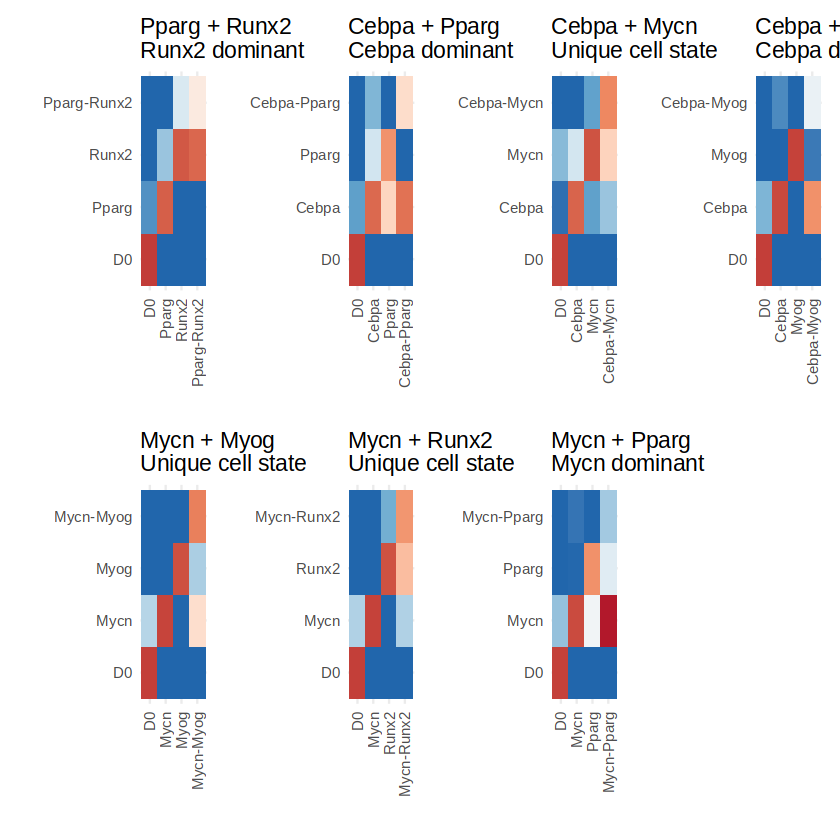

In [38]:
## Enrichment heatmaps
plots <- pmap(list(combinations, seu_diffexps, linkages, enrichments), function(combination, seu_diffexp, linkage, enrichment){
  seu_diffexp <- seu_diffexp[, seu_diffexp$Phase_corrected == "G1"]
  
  plotdata <- enrichment %>% reshape2::melt(varnames = c("condition_from", "condition_to"), value.name = "odds")
  
  title <- paste0(combination[[1]], " + ", combination[[2]])
  
  if (enrichment[4, 4] == max(enrichment[4, ])){
    title <- paste0(title, "\nUnique cell state")
  } else if (enrichment[4, 3] == max(enrichment[4, ])){
    title <- paste0(title, "\n", combination[[2]], " dominant")
  } else if (enrichment[4, 2] == max(enrichment[4, ])){
    title <- paste0(title, "\n", combination[[1]], " dominant")
  }
  
  plot <- ggplot(plotdata) + 
    geom_tile(aes(condition_from, condition_to, fill = log2(odds))) + 
    scale_fill_distiller(type = "div", palette = "RdBu", limits = c(-2.5, 2.5), oob = scales::squish) + 
    theme_minimal() +
    scale_x_discrete(name = "") +
    scale_y_discrete(name = "") +
    theme(legend.position = "none") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ggtitle(title)
  
  plot
})

plot<- patchwork::wrap_plots(plots[order], ncol = 4)
plot
ggsave(file.path(plot_folder, "dominant_unique_overview.png"), plot = plot, width = 12, height = 7)
normalizePath(file.path(plot_folder, "dominant_unique_overview.png"))


[1] "/srv/data/wouters/projects/tfseq/code/10_Combinations/output/main_tf/unique_pooled.pdf"

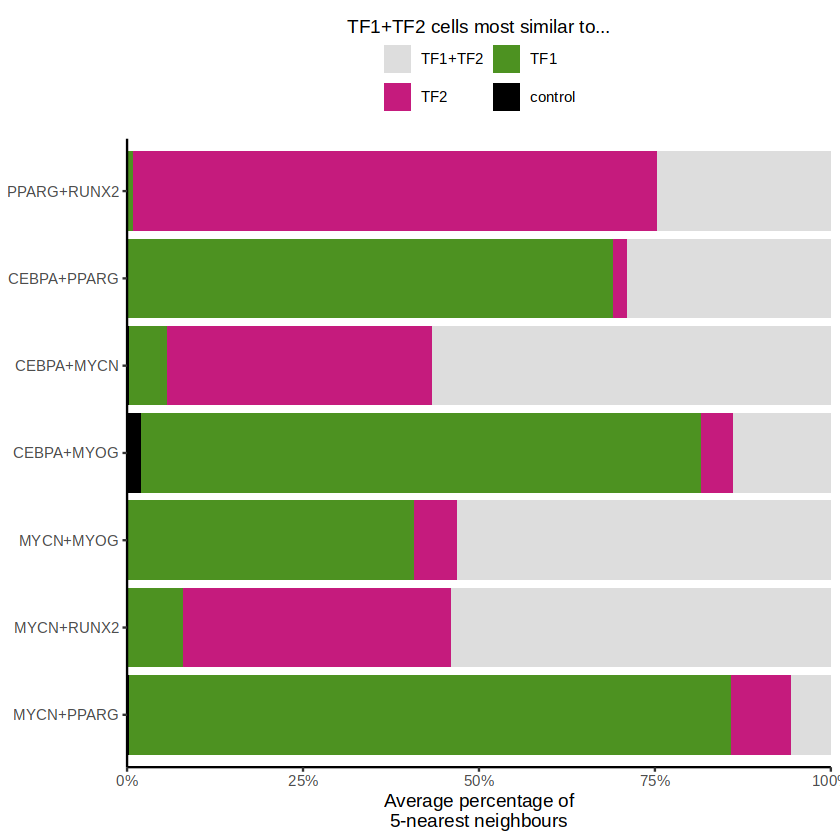

In [39]:

## Enrichment percentage curves of the combination
plotdata <- pmap_dfr(list(combinations, linkages, enrichments), function(combination, linkage, enrichment){
  condition_oi <- paste0(combination[[1]], "-", combination[[2]])
  combination_name <- paste0(toupper(combination[[1]]), "+", toupper(combination[[2]]))
  
  plotdata <- linkage %>% 
    filter(condition_from == condition_oi) %>% 
    group_by(condition_to) %>% 
    summarize(n = n()) %>% 
    mutate(perc = n/sum(n)) %>% 
    mutate(combination = combination_name) %>% 
    mutate(condition_to_int = as.character(as.numeric(condition_to)))
  plotdata
})

plotdata$combination <- factor(plotdata$combination, levels = rev(map_chr(combinations, ~paste0(toupper(.[[1]]), "+", toupper(.[[2]])))))

plot <- ggplot(plotdata %>% mutate(condition_to_int = factor(condition_to_int, levels = c("4", "3", "2", "1"))), aes(x = combination, y= perc, fill = condition_to_int)) + 
  geom_bar(position="fill", stat="identity") + 
  scale_fill_manual(
    values =  setNames(fourway_colors, c("1", "3", "2", "4")),
    labels = setNames(c("control", "TF1", "TF2", "TF1+TF2"), c("1", "2", "3", "4")),
    name = "TF1+TF2 cells most similar to..."
  ) +
  theme_classic() +
  coord_flip() +
  scale_y_continuous(limits = c(0, 1), expand = c(0, 0), name = "Average percentage of\n5-nearest neighbours", labels = scales::percent) +
  scale_x_discrete(name = NULL) +
  theme(legend.position="top") +
  guides(fill = guide_legend(title.position="top", title.hjust = 0.5, ncol = 2))
  # theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plot
ggsave(file.path(plot_folder, "unique_pooled.png"), plot = plot, width = 3, height = 3.5)
ggsave(file.path(plot_folder, "unique_pooled.pdf"), plot = plot, width = 3, height = 3.5)
normalizePath(file.path(plot_folder, "unique_pooled.pdf"))


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


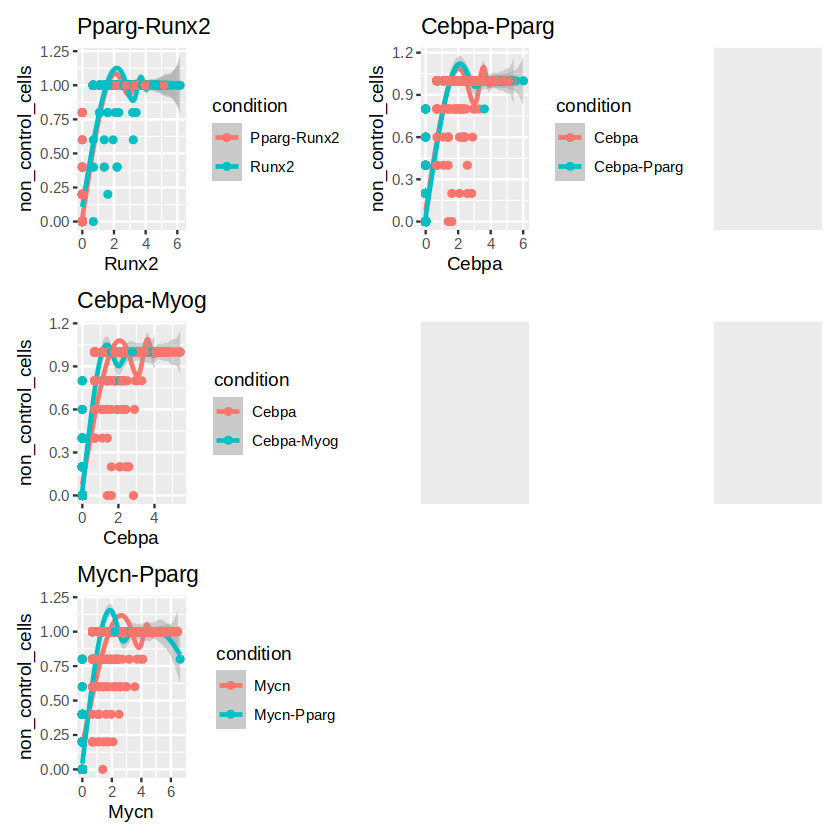

In [40]:

# Response curves dependent on vector and combinatorial
create_noncontrol_plotdata <- function(linkage, cell_info, condition_dominant, condition_shared) {
  plotdata <- linkage %>% mutate(non_control = condition_to != "D0") %>% group_by(cell_from) %>% summarize(non_control = mean(non_control))
  plotdata$cell <- plotdata$cell_from
  plotdata <- plotdata %>% left_join(cell_info, by = "cell") 
  plotdata <- bind_rows(
    plotdata %>% filter(condition %in% c(condition_dominant, condition_shared)),
    plotdata %>% filter(condition %in% c("D0")) %>% mutate(condition = condition_dominant),
    plotdata %>% filter(condition %in% c("D0")) %>% mutate(condition = condition_shared) %>% mutate(part = "shared_dominant")
  )
  plotdata
}

# main TF vs non control
plots <- pmap(list(combinations, seu_diffexps, linkages, enrichments), function(combination, seu_diffexp, linkage, enrichment){
  conditions_oi <- c("D0", combination[[1]], combination[[2]], paste0(combination[[1]], "-", combination[[2]]))
  
  if (enrichment[4, 4] == max(enrichment[4, ])){
    return(ggplot())
  } else if (enrichment[4, 3] == max(enrichment[4, ])){
    dominant <- 2
  } else if (enrichment[4, 2] == max(enrichment[4, ])){
    dominant <- 1
  }
  condition_dominant <- conditions_oi[[dominant + 1]]
  condition_shared <- conditions_oi[[4]]
  cell_info <- seu_diffexp@meta.data
  cell_info$ix <- 1:nrow(cell_info)
  plotdata <- create_noncontrol_plotdata(linkage, cell_info, condition_dominant, condition_shared)
  
  sym <- rlang::sym(paste0("logvector", dominant))
  ggplot(plotdata, aes(!!sym, non_control, color = condition)) + 
    geom_smooth(aes()) + 
    geom_point() +
    scale_x_continuous(name = conditions_oi[[dominant+1]]) + 
    scale_y_continuous(name = "non_control_cells") +
    ggtitle(conditions_oi[[4]])
})
patchwork::wrap_plots(plots)


[1] "D0"          "Pparg"       "Runx2"       "Pparg-Runx2"
[1] "D0"          "Pparg"       "Runx2"       "Pparg-Runx2"
[1] "D0"          "Cebpa"       "Pparg"       "Cebpa-Pparg"
[1] "D0"          "Cebpa"       "Pparg"       "Cebpa-Pparg"
[1] "D0"         "Cebpa"      "Mycn"       "Cebpa-Mycn"
[1] "D0"         "Cebpa"      "Mycn"       "Cebpa-Mycn"
[1] "D0"         "Cebpa"      "Myog"       "Cebpa-Myog"
[1] "D0"         "Cebpa"      "Myog"       "Cebpa-Myog"
[1] "D0"        "Mycn"      "Myog"      "Mycn-Myog"
[1] "D0"        "Mycn"      "Myog"      "Mycn-Myog"
[1] "D0"         "Mycn"       "Runx2"      "Mycn-Runx2"
[1] "D0"         "Mycn"       "Runx2"      "Mycn-Runx2"
[1] "D0"         "Mycn"       "Pparg"      "Mycn-Pparg"
[1] "D0"         "Mycn"       "Pparg"      "Mycn-Pparg"


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“at  -0.02683”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“radius  0.00071984”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“all data on boundary of neighborhood. make span bigger”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.02683”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.02683”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1”
War

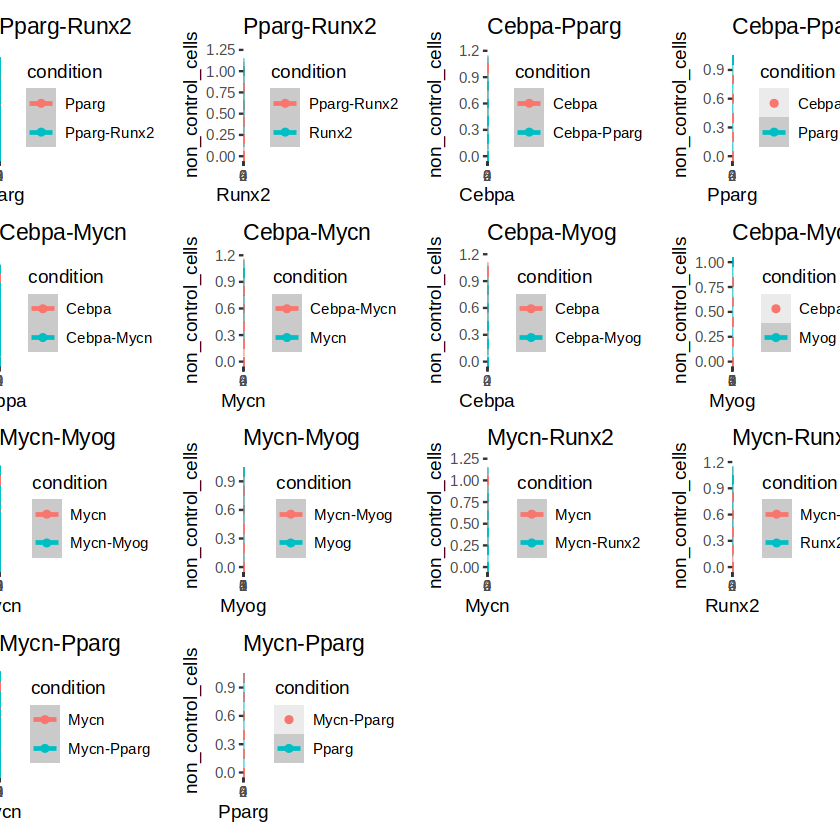

In [41]:
# all TFs vs non control
plots <- pmap(list(combinations, seu_diffexps, linkages, enrichments), function(combination, seu_diffexp, linkage, enrichment){
  plots <- list()
  
  conditions_oi <- c("D0", combination[[1]], combination[[2]], paste0(combination[[1]], "-", combination[[2]]))
  
  plots <- map(c(1, 2), function(dominant) {
    print(conditions_oi)
    condition_dominant <- conditions_oi[[dominant + 1]]
    condition_shared <- conditions_oi[[4]]
    cell_info <- seu_diffexp@meta.data
    cell_info$ix <- 1:nrow(cell_info)
    plotdata <- create_noncontrol_plotdata(linkage, cell_info, condition_dominant, condition_shared)
    
    sym <- rlang::sym(paste0("logvector", dominant))
    ggplot(plotdata, aes(!!sym, non_control, color = condition)) + 
      geom_smooth(aes()) + 
      geom_point() +
      scale_x_continuous(name = conditions_oi[[dominant+1]]) + 
      scale_y_continuous(name = "non_control_cells") +
      ggtitle(conditions_oi[[4]])
  })
})
patchwork::wrap_plots(unlist(plots, recursive = FALSE))


In [44]:

# 
# diffexps <- pmap(list(combinations, seu_diffexps), function(combination, seu_diffexp) {
#   scores <- read_rds(file.path(scores_folder, paste0(combination[[1]], "_", combination[[2]], ".rds")))
#   scores$symbol <- data.annot %>% slice(match(scores$gene, gene)) %>% pull(gene_short_name)
#   scores <- scores %>% filter(gene %in% seu_diffexp@assays$RNA@meta.features$gene)
#   scores
# })


# main TF vs main diffexp
ix <- 6
combination <- combinations[[ix]]
combination
seu_diffexp <- seu_diffexps[[ix]]
linkage <- linkages[[ix]]
enrichment <- enrichments[[ix]]
plots <- pmap(list(combinations, seu_diffexps, linkages, enrichments, diffexps), function(combination, seu_diffexp, linkage, enrichment, diffexp){
  conditions_oi <- c("D0", combination[[1]], combination[[2]], paste0(combination[[1]], "-", combination[[2]]))
  
  # determine main TF and create plotdata
  if (enrichment[4, 3] > max(enrichment[4, 2])){
    dominant <- 2
  } else {
    dominant <- 1
  }
  condition_dominant <- conditions_oi[[dominant + 1]]
  condition_shared <- conditions_oi[[4]]
  cell_info <- seu_diffexp@meta.data
  cell_info$ix <- 1:nrow(cell_info)
  plotdata <- create_noncontrol_plotdata(linkage, cell_info, condition_dominant, condition_shared)
  
  # load diffexp scores
  sym <- rlang::sym(paste0("logFC_", dominant))
  markers <- diffexp %>% arrange(desc(!!sym)) %>% head(20) %>% pull(symbol)
  print(markers)
  
  # add score
  seu_diffexp <- AddModuleScore(seu_diffexp, (data.annot %>% filter(symbol %in% markers) |> pull(gene)), name = "markers")
  plotdata$score <- seu_diffexp@meta.data[plotdata$cell, "markers1"]
  
  sym <- rlang::sym(paste0("logvector", dominant))
  ggplot(plotdata, aes(!!sym, score, color = condition)) + 
    geom_smooth(aes()) + 
    # geom_point() +
    scale_x_continuous(name = condition_dominant) + 
    scale_y_continuous(name = "module score") +
    scale_color_manual(values = setNames(c("black", "orange"), c(condition_dominant, condition_shared))) +
    theme_minimal() +
    ggtitle(condition_shared) +
    theme(legend.position = "null")
})
plot <- patchwork::wrap_plots(plots, ncol = 7) + patchwork::plot_annotation(
  title = 'Module score of top 20 differentially expressed genes of main TF',
)
plot_folder <- file.path(plot_folder, "main_tf/")
dir.create(plot_folder, showWarnings = FALSE)
ggsave(file.path(plot_folder, "module_scores.png"), plot, width = 21, height = 3)


[1] "Mycn"  "Runx2"

 [1] "Tmem114"  "Klhl40"   "Ifitm1"   "Tspan32"  "Smim5"    "Gzmc"    
 [7] "Bglap2"   "Bglap"    "Cemip"    "Lrp8"     "Tgfa"     "Gzmb"    
[13] "Trarg1"   "Klhl5"    "Cyp26b1"  "Serping1" "Wnt7b"    "Endou"   
[19] "Dnajc10"  "Foxs1"   
 [1] "Lcn2"    "S100a8"  "Fabp4"   "Retn"    "Wfdc21"  "Cfd"     "Lpl"    
 [8] "Adipoq"  "C3"      "Orm1"    "Fcor"    "Plin1"   "Hp"      "Dgat2"  
[15] "Orm2"    "Hsd11b1" "Acsl1"   "Ngp"     "Pnpla2"  "Nabp1"  
 [1] "Mycn"    "Slpi"    "Fabp4"   "Wfdc21"  "Ramp3"   "Dusp2"   "Gpd1"   
 [8] "Ncl"     "Ly6e"    "Dkc1"    "Srm"     "Fabp5"   "Aldh3a1" "Rgcc"   
[15] "Wdr43"   "Fam162a" "Ddx21"   "Nolc1"   "Nhp2"    "Car9"   
 [1] "Lcn2"    "S100a8"  "Retn"    "Wfdc21"  "Fabp4"   "Cfd"     "C3"     
 [8] "Orm1"    "Lpl"     "Adipoq"  "Fcor"    "Hp"      "Plin1"   "Dgat2"  
[15] "Orm2"    "Ngp"     "Hsd11b1" "Acsl1"   "Pnpla2"  "Nabp1"  
 [1] "Mycn"    "Fabp4"   "Slpi"    "Wfdc21"  "Gpd1"    "Ramp3"   "Ncl"    
 [8] "Ly6e"    "Dusp2"   "Adipoq"  "Dkc1

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“at  -0.02683”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“radius  0.00071984”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“all data on boundary of neighborhood. make span bigger”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.02683”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborh

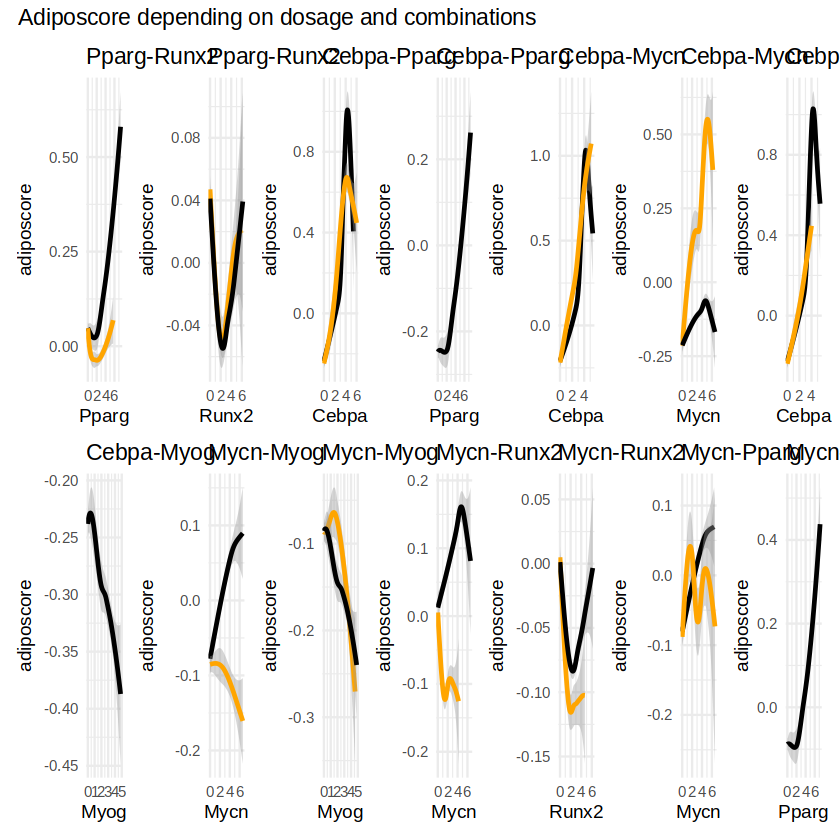

In [46]:

# adiposcore
plot_folder <- file.path(output_folder, "main_tf/")
plots <- pmap(list(combinations, seu_diffexps, linkages, enrichments, diffexps), function(combination, seu_diffexp, linkage, enrichment, diffexp){
  conditions_oi <- c("D0", combination[[1]], combination[[2]], paste0(combination[[1]], "-", combination[[2]]))
  
  map(c(1, 2), function(dominant) {
    condition_dominant <- conditions_oi[[dominant + 1]]
    condition_shared <- conditions_oi[[4]]
    cell_info <- seu_diffexp@meta.data
    cell_info$ix <- 1:nrow(cell_info)
    plotdata <- create_noncontrol_plotdata(linkage, cell_info, condition_dominant, condition_shared)
    plotdata_points <- 
    
    # add score
    plotdata$score <- plotdata$adiposcore1
    
    sym <- rlang::sym(paste0("logvector", dominant))
    plot <- ggplot(plotdata, aes(!!sym, score, color = condition)) + 
      geom_smooth(aes()) + 
      geom_point(aes(color = condition), size = 0.5, data = plotdata %>% filter(part != "shared_dominant")) + 
      scale_x_continuous(name = condition_dominant) + 
      scale_y_continuous(name = "adiposcore") +
      scale_color_manual(values = setNames(c("black", "orange"), c(condition_dominant, condition_shared))) +
      theme_minimal() +
      ggtitle(condition_shared) +
      theme(legend.position = "null")
    ggsave(file.path(plot_folder, paste0(conditions_oi[[4]], "_", dominant, "_adiposcore.png")), plot, width = 3, height = 3)
    ggsave(file.path(plot_folder, paste0(conditions_oi[[4]], "_", dominant, "_adiposcore.pdf")), plot, width = 3, height = 3)
    plot
  })
})
plot <- patchwork::wrap_plots(unlist(plots, recursive = FALSE), ncol = 7) + patchwork::plot_annotation(
  title = 'Adiposcore depending on dosage and combinations',
)
plot
dir.create(plot_folder, showWarnings = FALSE)
ggsave(file.path(plot_folder, "adiposcore.png"), plot, width = 21, height = 6)


[1] "Cebpa" "Mycn"

[1] "ENSMUSG00000062515"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


[1] "ENSMUSG00000015568"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


[1] "ENSMUSG00000000440"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


[1] "ENSMUSG00000003123"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


[1] "ENSMUSG00000022878"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


[1] "ENSMUSG00000002944"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


[1] "ENSMUSG00000002831"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


[1] "ENSMUSG00000028494"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


[1] "ENSMUSG00000030546"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


[1] "ENSMUSG00000034957"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


[1] "ENSMUSG00000056501"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


[1] "ENSMUSG00000030278"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


[1] "/srv/data/wouters/projects/tfseq/code/07_Combinations/output/main_tf//main_tf//markers_adiposcore_Cebpa_Cebpa-Mycn.pdf"

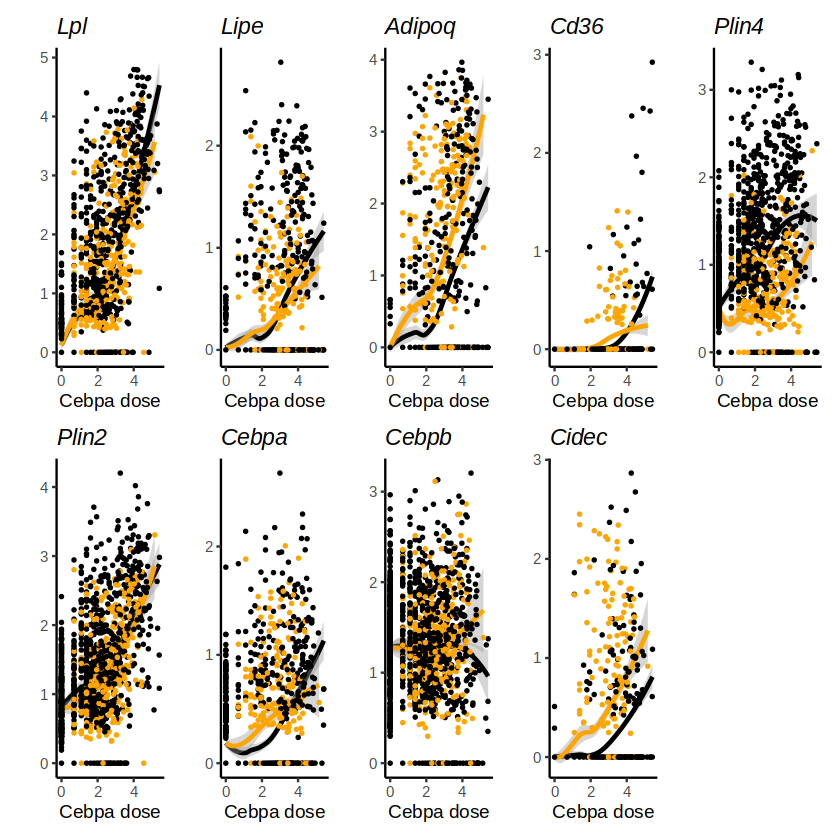

In [59]:

# All adipo genes individual & combined plots
# Select a combination
plot_folder <- file.path(output_folder, "main_tf/")
ix <- 3 # CEBPA+MYCN
combination <- combinations[[ix]]
combination
seu_diffexp <- seu_diffexps[[ix]]
linkage <- linkages[[ix]]
enrichment <- enrichments[[ix]]
diffexp <- diffexps[[ix]]

conditions_oi <- c("D0", combination[[1]], combination[[2]], paste0(combination[[1]], "-", combination[[2]]))
dominant <- 1
condition_dominant <- conditions_oi[[dominant + 1]]
condition_shared <- conditions_oi[[4]]
cell_info <- seu_diffexp@meta.data
cell_info$ix <- 1:nrow(cell_info)
plotdata <- create_noncontrol_plotdata(linkage, cell_info, condition_dominant, condition_shared)

markers <-  c("Fabp4", "Lpl", "Pparg", "Lipe", "Adipoq", "Cd36",
                    "Plin4", "Plin2", "Plin1", "Cebpa", "Cebpb",
                    "Cidec")
# markers <- scores %>% arrange(logFC_12) %>% head(12) %>% pull(symbol)
# markers <- scores %>% arrange(-logFC_12) %>% head(12) %>% pull(symbol)
# markers <- scores %>% arrange(-logFC_1) %>% head(12) %>% pull(symbol)
genes <- data.annot %>% dplyr::slice(match(markers, symbol)) %>% pull(gene)

# diffexp %>% select(logFC_1, logFC_2, logFC_12, symbol) %>% slice(match(markers, symbol))

# Individual markers, line based on main
sym <- rlang::sym(paste0("logvector", dominant))
plots <- map(markers, function(symbol_oi) {
  gene_oi <- rownames(data.annot %>% filter(symbol == !!symbol_oi))
  print(gene_oi)
  plotdata$score <- seu_diffexp@assays$RNA@data[gene_oi, plotdata$cell]
  # remove duplicate x/y coordinates
  plotdata_point <- plotdata %>% distinct(!!sym, score, .keep_all = TRUE)
  plot <- ggplot(plotdata, aes(!!sym, score)) +
    geom_smooth(aes(color = condition), method = "loess") + 
    scale_x_continuous(name = paste0(condition_dominant, " dose")) + 
    scale_y_continuous(name = "") +
    geom_point(aes(color = condition), size = 0.5, data = plotdata_point %>% filter(is.na(part))) + 
    scale_color_manual(values = setNames(c("black", "orange"), c(condition_dominant, condition_shared))) +
    theme_classic() +
    ggtitle(symbol_oi) +
    theme(legend.position = "none") +
    theme(plot.title = element_text(face = "italic"))
  ggsave(file.path(plot_folder, paste0(conditions_oi[[4]], "_", dominant, "_", symbol_oi, ".png")), plot, width = 3, height = 2.5)
  ggsave(file.path(plot_folder, paste0(conditions_oi[[4]], "_", dominant, "_", symbol_oi, ".pdf")), plot, width = 3, height = 2.5)
  plot
})
plot_folder <- file.path(plot_folder, "main_tf/")
plot <- patchwork::wrap_plots(plots[c(2, 4, 5, 6, 7, 8, 10, 11, 12)], ncol = 5)
plot
path <- file.path(plot_folder, paste0("markers_adiposcore_", condition_dominant, "_", condition_shared, ".png"))
ggsave(path, plot, width = 2.5*5, height = 2.5*1.5)
path <- file.path(plot_folder, paste0("markers_adiposcore_", condition_dominant, "_", condition_shared, ".pdf"))
ggsave(path, plot, width = 2.5*5, height = 2.5*1.5)
path



[1] "ENSMUSG00000062515"
[1] "ENSMUSG00000015568"
[1] "ENSMUSG00000000440"
[1] "ENSMUSG00000003123"
[1] "ENSMUSG00000022878"
[1] "ENSMUSG00000002944"
[1] "ENSMUSG00000002831"
[1] "ENSMUSG00000028494"
[1] "ENSMUSG00000030546"
[1] "ENSMUSG00000034957"
[1] "ENSMUSG00000056501"
[1] "ENSMUSG00000030278"


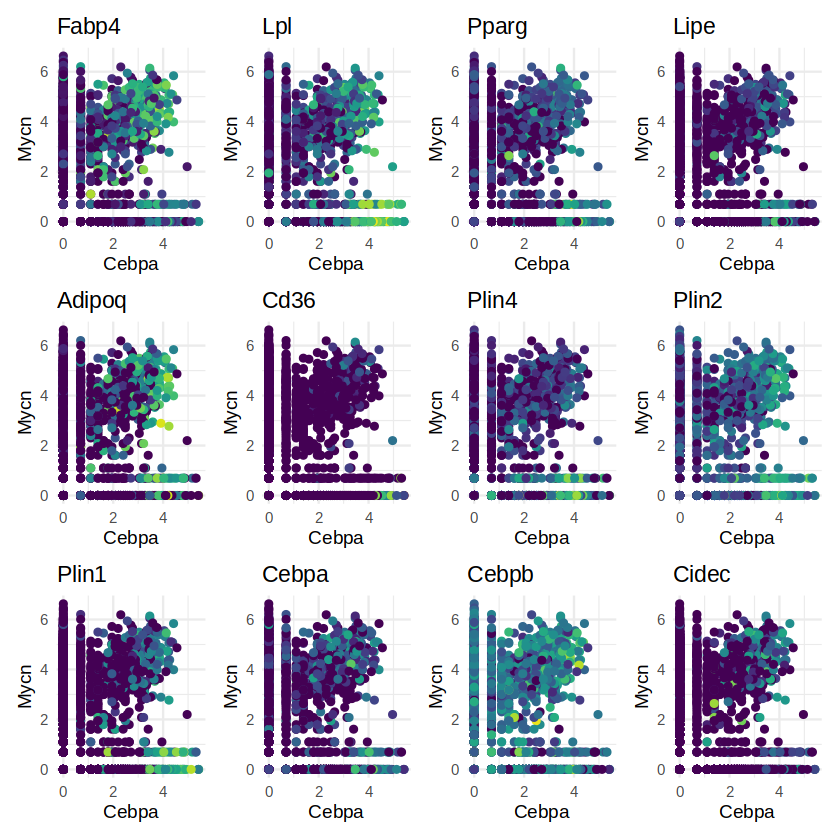

In [53]:

# Individual markers, scatter
plotdata <- cell_info
plots <- map(markers, function(symbol_oi) {
  gene_oi <- rownames(data.annot %>% filter(symbol == !!symbol_oi))
  print(gene_oi)
  plotdata$score <- seu_diffexp@assays$RNA@data[gene_oi, plotdata$cell]
  plot <- ggplot(plotdata) +
    scale_x_continuous(name = conditions_oi[[2]]) + 
    scale_y_continuous(name = conditions_oi[[3]]) + 
    geom_point(aes(logvector1, logvector2, color = score)) +
    theme_minimal() +
    scale_color_viridis() +
    ggtitle(symbol_oi) +
    theme(legend.position = "none")
  plot
})
patchwork::wrap_plots(plots)


`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'bin1'. You can override using the
`.groups` argument.

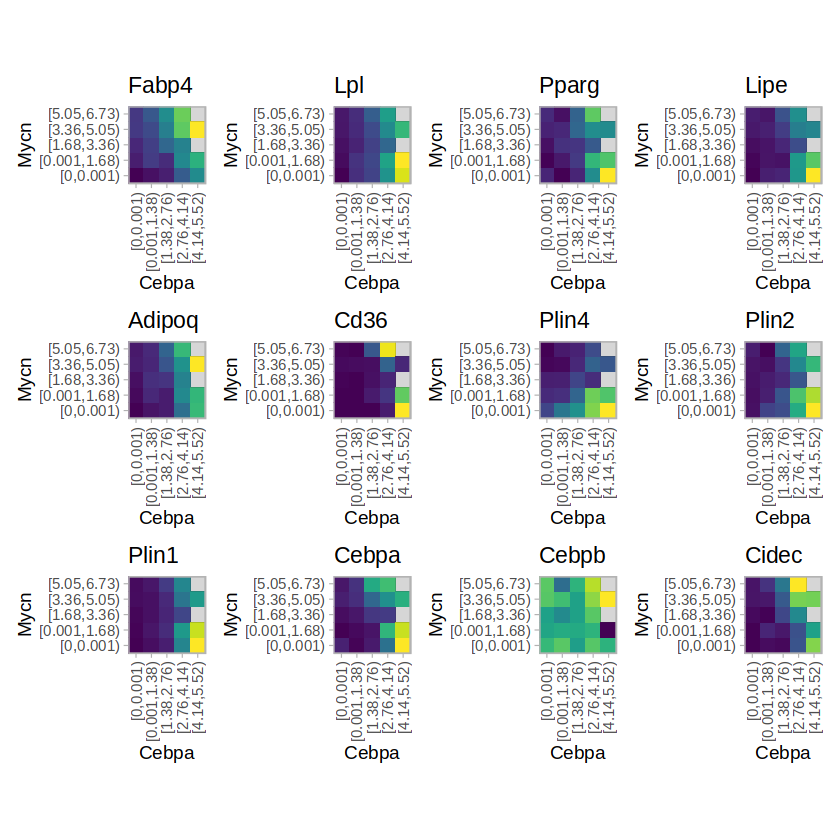

In [54]:

# Individual markers, heatmap
plotdata <- seu_diffexp@meta.data

theme_heatmap <- function(plot, combination){
  plot +
    scale_x_discrete(expand = c(0, 0), name = combination[[1]],) +
    scale_y_discrete(expand = c(0, 0), name = combination[[2]]) +
    coord_fixed() + 
    theme_light() +
    theme(legend.position="none") +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
}

plots <- map(markers, function(symbol_oi) {
  gene_oi <- rownames(data.annot %>% filter(symbol == !!symbol_oi))
  plotdata$score <- seu_diffexp@assays$RNA@data[gene_oi, plotdata$cell]
  
  summarized <- plotdata %>% group_by(bin1, bin2) %>% dplyr::summarize(score = mean(score), n = n())
  n_cells_cutoff <- 5
  summarized <- summarized %>% mutate(score = ifelse(n < n_cells_cutoff, NaN, score))
  
  plot <- ggplot(summarized, aes(bin1, bin2, fill= score)) + 
    geom_tile() +
    # geom_text(aes(label = n), size = 2) +
    scale_fill_viridis(na.value = "#33333333") +
    ggtitle(symbol_oi)
  plot <- plot %>% theme_heatmap(combination)
  ggsave(file.path(plot_folder, paste0(conditions_oi[[4]], "_", dominant, "_", symbol_oi, "_heatmap.png")), plot, width = 3, height = 2.5)
  ggsave(file.path(plot_folder, paste0(conditions_oi[[4]], "_", dominant, "_", symbol_oi, "_heatmap.pdf")), plot, width = 3, height = 2.5)
  plot
})

patchwork::wrap_plots(plots)





